In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For i/o paths
from pathlib import Path

# For map visualization
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import mapviz

# For manipulating lines
from matplotlib.collections import LineCollection

In [2]:
import matplotlib.patches as mpatches

In [3]:
# Data paths
pop_dir = Path().resolve().parent / 'original' / 'population'
pop_center_file = pop_dir / 'population_center_2020.xlsx'

mea_dir = Path().resolve().parent / 'original' / 'japan_MetropolitanEmploymentArea2015map'
shpfile_mea = mea_dir / 'japan_MetropolitanEmploymentArea2015map.shp'

ward_dir = Path().resolve().parent / 'original' / 'ward_shapefiles'

figdir = Path().resolve().parent / 'figure'

In [4]:
# Plot settings
plt.rcParams['font.family'] = ['sans-serif', 'serif']
plt.rcParams["font.sans-serif"] = ['Helvetica']
plt.rcParams['font.serif'] = ['Palatino']
SMALL_FONT_SIZE = 10
MEDIUM_FONT_SIZE = 11.5
LARGE_FONT_SIZE = 13
PANEL_LABEL_SIZE = 16
PANEL_LABEL_FONT = 'DejaVu Sans'
plt.rcParams.update({'font.size': MEDIUM_FONT_SIZE})

In [5]:
def dms2dd(dms):
    '''Convert the degrees, minutes, seconds notation to decimal degrees'''
    return dms[0] + dms[1] / 60 + dms[2] / 3600

# Reachable extreme points of Japan
east_ext = dms2dd((145, 48, 58))
west_ext = dms2dd((122, 56, 1))
south_ext = dms2dd((24, 2, 59))
north_ext = dms2dd((45, 31, 22))

center_lon = dms2dd((139, 44, 28))
center_lat = dms2dd((35, 39, 29))
lon_diff = east_ext - west_ext
lat_diff = north_ext - south_ext
extent = (west_ext-lon_diff*0.05, east_ext+lon_diff*0.05, 
          south_ext-lat_diff*0.05, north_ext+lat_diff*0.05)

lambert_area_proj = ccrs.LambertAzimuthalEqualArea(
    central_longitude=center_lon, 
    central_latitude=center_lat)

In [6]:
# Read the data where the population center of each municipality is given.
pop_center_df_dict = pd.read_excel(pop_center_file,
                                   sheet_name=None, engine='openpyxl', skiprows=1, 
                                   dtype={'コード': str})

# Concatenate the dataframes
pop_center_df = pd.DataFrame()
for df in pop_center_df_dict.values():
    pop_center_df = pd.concat([pop_center_df, df])

# Drop duplicates and rename columns
pop_center_df = pop_center_df.drop_duplicates(subset='コード')\
    .rename(columns={'コード': 'code', '名称': 'name', '10進緯度': 'lat', '10進経度': 'lon', '人口': 'pop'})\
    .set_index('code')

# Each prefecture is assigned a unique code. Make a dictionary for the conversion.
pref_name2code = pop_center_df[pop_center_df.index.str.endswith('000')]['name']\
    .str.replace('都$|府$|県$', '', regex=True)
pref_name2code = dict(zip(pref_name2code, pref_name2code.index))

In [7]:
# Get shapefiles of prefectures
shpfile_pref = shpreader.natural_earth(resolution='10m', category='cultural', 
                                       name='admin_1_states_provinces')
pref_shape_dict = {pref.attributes['name'].translate(str.maketrans({'Ō': 'O', 'ō' : 'o'})): pref.geometry 
                   for pref in shpreader.Reader(shpfile_pref).records()
                   if pref.attributes['admin'] == 'Japan'}
print('Number of prefectures:', len(pref_shape_dict))

Number of prefectures: 47


In [8]:
region_names = [('東北', 'Tohoku'), ('関東', 'Kanto'), ('東海','Tokai'), ('関西', 'Kansai'), 
                ('四国', 'Shikoku'), ('九州', 'Kyushu')]

region_to_pref_dict = {
    'Tohoku': [('青森', 'Aomori'), ('岩手', 'Iwate'), ('宮城', 'Miyagi'), ('秋田', 'Akita'), 
           ('山形', 'Yamagata'), ('福島', 'Fukushima')], 
    'Kanto': [('東京', 'Tokyo'), ('神奈川', 'Kanagawa'), ('埼玉', 'Saitama'), ('千葉', 'Chiba'), 
           ('茨城', 'Ibaraki'), ('栃木', 'Tochigi'), ('群馬', 'Gunma')],
    'Tokai': [('愛知', 'Aichi'), ('三重', 'Mie'), ('岐阜', 'Gifu'), ('静岡', 'Shizuoka')],
    'Kansai': [('大阪', 'Osaka'), ('京都', 'Kyoto'), ('兵庫', 'Hyogo'), ('奈良', 'Nara'), 
           ('滋賀', 'Shiga'), ('和歌山', 'Wakayama')],
    'Shikoku': [('愛媛', 'Ehime'), ('香川', 'Kagawa'), ('徳島', 'Tokushima'), ('高知', 'Kochi')],
    'Kyushu': [('福岡', 'Fukuoka'), ('佐賀', 'Saga'), ('長崎', 'Nagasaki'), ('熊本', 'Kumamoto'),
           ('大分', 'Oita'), ('宮崎', 'Miyazaki'), ('鹿児島', 'Kagoshima')]
}

region_shape_dict = {region: [pref_shape_dict[pref[1]] for pref in prefs] 
                     for region, prefs in region_to_pref_dict.items()}

# Calculate the center of population for each region
def calc_region_pop_center(pref_codes, pop_center_df):
    pop_center = pop_center_df[pop_center_df.index.isin(pref_codes)]
    pop = pop_center['pop'].sum()
    lat = (pop_center['lat'] * pop_center['pop']).sum() / pop
    lon = (pop_center['lon'] * pop_center['pop']).sum() / pop
    return lon, lat

# Determine the coordinates of each region
region_coords = {region: calc_region_pop_center([pref_name2code[pref[0]] for pref in prefs], pop_center_df) 
                 for region, prefs in region_to_pref_dict.items()}

In [9]:
pref_names = [('愛知', 'Aichi'), ('群馬', 'Gunma'), ('石川', 'Ishikawa'), ('香川', 'Kagawa'), 
              ('滋賀', 'Shiga'), ('宮城', 'Miyagi')]
pref_coords = {pref_en: pop_center_df.loc[pref_name2code[pref_jp], ['lon', 'lat']].tolist() 
               for pref_jp, pref_en in pref_names}

In [10]:
city_names = [('京都', 'Kyoto'), ('名古屋', 'Nagoya'), ('福岡', 'Fukuoka'), ('広島', 'Hiroshima'), 
              ('仙台', 'Sendai'), ('札幌', 'Sapporo')]
city_name2code = {'京都': '26100', '名古屋': '23100', '福岡': '40130', '広島': '34100', 
                  '仙台': '04100', '札幌': '01100'}
city_coords = {city_en: pop_center_df.loc[city_name2code[city_jp], ['lon', 'lat']].tolist() 
               for city_jp, city_en in city_names}

# Get shapefiles of metropolitan employment areas (MEAs)
mea_shape_dict = {mea.attributes['MEA_Name']: mea.geometry 
                  for mea in shpreader.Reader(shpfile_mea).records()}
print('Number of MEAs:', len(mea_shape_dict))

# The city name and MEA name is not exactly the same.
# Make a dictionary to convert city names to MEA names.
city_name_to_mea_name = {}
for city_jp, city_en in city_names:
    for mea_name in mea_shape_dict.keys():
        if city_en in mea_name:
            print(city_en, city_jp, mea_name)
            city_name_to_mea_name[city_en] = mea_name
city_shape_dict = {city_name: mea_shape_dict[mea_name] 
                   for city_name, mea_name in city_name_to_mea_name.items()}

Number of MEAs: 100
Kyoto 京都 Kyoto-Kusatsu
Nagoya 名古屋 Nagoya
Fukuoka 福岡 Fukuoka
Hiroshima 広島 Hiroshima
Sendai 仙台 Sendai
Sapporo 札幌 Sapporo-Otaru


In [11]:
ward_names = [('渋谷', 'Shibuya'), ('新宿', 'Shinjuku'), ('博多', 'Hakata'), ('大宮', 'Omiya'), 
              ('天王寺', 'Tennoji'), ('世田谷', 'Setagaya')]
ward_name2code = {'渋谷': '13113', '新宿': '13104', '博多': '40132', '大宮': '11103', 
                  '天王寺': '27109', '世田谷': '13112'}
ward_coords = {ward_en: pop_center_df.loc[ward_name2code[ward_jp], ['lon', 'lat']].tolist() 
               for ward_jp, ward_en in ward_names}

# Get shapefiles of wards and make a dictionary
ward_shape_dict = {}
for ward_jp, ward_en in ward_names:
    ward_code = ward_name2code[ward_jp]
    shpfile_ward = ward_dir / f'A002005532016DDSWC{ward_code}-JGD2011' / f'h28ca{ward_code}.shp'
    ward_shape_dict[ward_en] = [ward.geometry for ward in shpreader.Reader(shpfile_ward, encoding='shift-jis').records()]

In [12]:
def plot_map_with_toponyms(ax, names, shapes, colors, coords, *, 
                           text_offset_dict, text_arrow_vec, text_offset_coeff, toponym_fontsize):
    for (_, name_en), color in zip(names, colors):
        shape_feature = cfeature.ShapelyFeature(shapes[name_en], ccrs.PlateCarree(),
                                                linewidth=0, facecolor=color, edgecolor='none', alpha=0.9)
        ax.add_feature(shape_feature)
        offset_len = text_offset_dict[name_en]
        offset = offset_len * text_arrow_vec
        text_ha = 'left' if offset_len > 0 else 'right'
        arrow_offset = text_offset_coeff * ((offset_len > 0) * 2 - 1) * text_arrow_vec
        ax.text(coords[name_en][0]+offset[0], coords[name_en][1]+offset[1], 
                         name_en, transform=ccrs.PlateCarree(), 
                         fontsize=toponym_fontsize, color='black', ha=text_ha, va='center')
        lc = LineCollection([[
            (coords[name_en][0]+offset[0]-arrow_offset[0], 
             coords[name_en][1]+offset[1]-arrow_offset[1]), 
            (coords[name_en][0]+arrow_offset[0], 
             coords[name_en][1]+arrow_offset[1])]], 
            transform=ccrs.PlateCarree(), color='black', linewidth=0.2)
        ax.add_collection(lc)

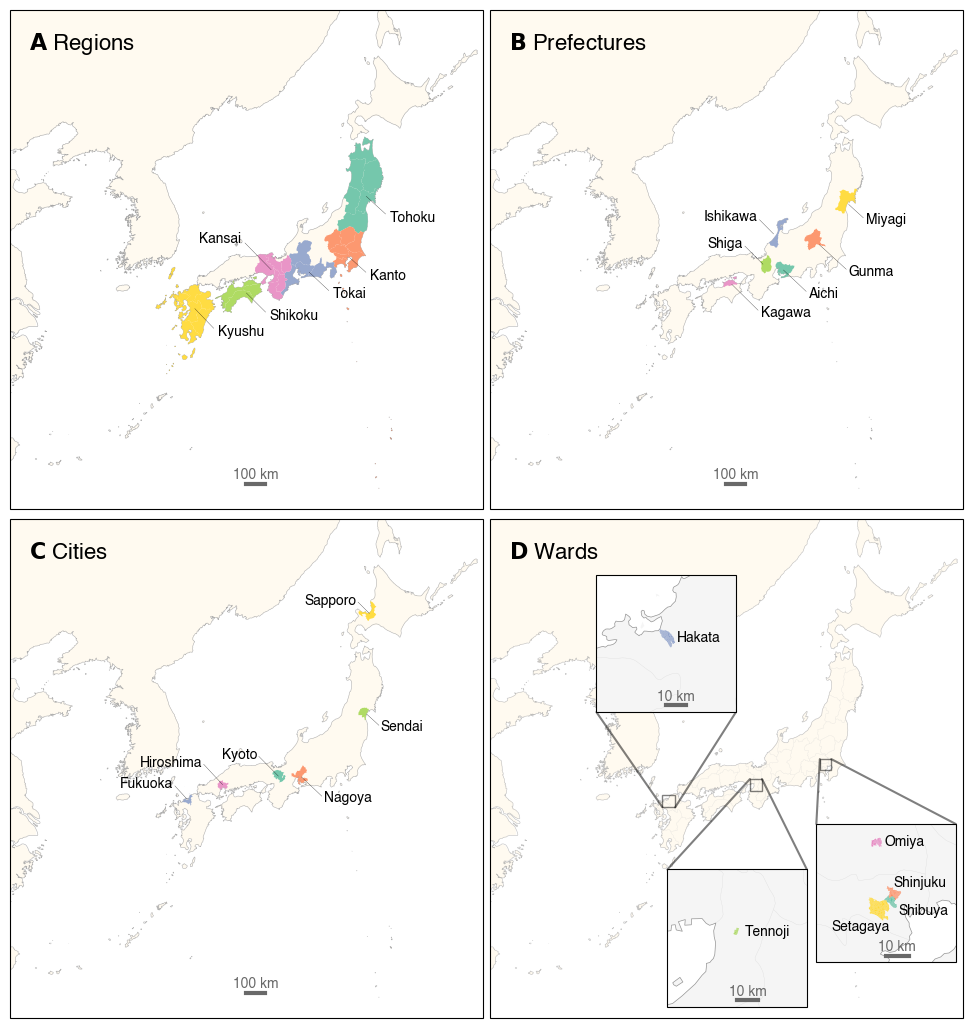

In [13]:
two_by_two = True
figsize = (10, 10.5) if two_by_two else (10, 3.33)
subplot_nrows_ncols = (2, 2) if two_by_two else (1, 4)

fig, axes = plt.subplots(*subplot_nrows_ncols, figsize=figsize, 
                         subplot_kw={'projection': lambert_area_proj},
                         gridspec_kw={'hspace': 0.02, 'wspace': 0})
if two_by_two:
    axes = axes.flatten()

cmap = plt.colormaps['Set2']
toponym_fontsize = SMALL_FONT_SIZE if two_by_two else MEDIUM_FONT_SIZE
panel_title_fontsize = PANEL_LABEL_SIZE if two_by_two else LARGE_FONT_SIZE
panel_title_loc = (0.04, 0.92) if two_by_two else (0.04, 0.9)
scale_bar_loc = (0.5, 0.05)
inset_scale_bar_loc = (0.5, 0.05)
map_kwargs = dict(color='darkgrey', resolution='10m', lw=0.4)
ward_inset_kwargs = dict(resolution='10m', color='dimgrey', lw=0.5, alpha=0.7)
main_pref_kwargs = dict(lw=0.1, facecolor='none', edgecolor='lightgrey', alpha=0.7)
inset_pref_kwargs = dict(lw=0.2, facecolor='none', edgecolor='lightgrey', alpha=0.9)
scale_bar_kwargs = dict(color='dimgrey', text_kwargs={'size': toponym_fontsize})

text_offset = {
    'Tohoku': 1.4, 'Kanto': 1.2, 'Tokai': 1.4, 'Kansai': -1.8, 'Shikoku': 1.4, 'Kyushu': 1.4,
    'Aichi': 1.4, 'Gunma': 1.6, 'Ishikawa': -1, 'Kagawa': 1.6, 'Shiga': -1.2, 'Miyagi': 1, 
    'Kyoto': -1.2, 'Nagoya': 1.2, 'Fukuoka': -0.8, 'Hiroshima': -1.2, 'Sendai': 0.8, 'Sapporo': -0.8, 
    'Shibuya': (0.04, -0.04), 'Shinjuku': (0, 0.04), 'Hakata': (0.06, 0), 
    'Omiya': (0.04, 0), 'Tennoji': (0.04, 0), 'Setagaya': (-0.24, -0.08)}
text_arrow_vec = np.array((1.2, -0.9))

ax = axes[0]
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, **map_kwargs)
colors = [cmap(i) for i in range(len(region_names))]
plot_map_with_toponyms(ax, region_names, region_shape_dict, colors, region_coords,
                       text_offset_dict=text_offset, text_arrow_vec=text_arrow_vec, 
                       text_offset_coeff=0.2, toponym_fontsize=toponym_fontsize)
mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=100, **scale_bar_kwargs)
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
ax.text(*panel_title_loc, r'$\bf{A}$ ' + 'Regions', 
        transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.set_frame_on(True)

ax = axes[1]
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, alpha=0.9, **map_kwargs)
colors = [cmap(i) for i in range(len(pref_names))]
plot_map_with_toponyms(ax, pref_names, pref_shape_dict, colors, pref_coords, 
                       text_offset_dict=text_offset, text_arrow_vec=text_arrow_vec, 
                       text_offset_coeff=0.12, toponym_fontsize=toponym_fontsize)
mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=100, **scale_bar_kwargs)
ax.text(*panel_title_loc, r'$\bf{B}$ ' + 'Prefectures', transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
ax.set_frame_on(True)

ax = axes[2]
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, alpha=0.9, **map_kwargs)
colors = [cmap(i) for i in range(len(city_names))]
plot_map_with_toponyms(ax, city_names, city_shape_dict, colors, city_coords, 
                       text_offset_dict=text_offset, text_arrow_vec=text_arrow_vec, 
                       text_offset_coeff=0.08, toponym_fontsize=toponym_fontsize)
mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=100, **scale_bar_kwargs)
ax.text(*panel_title_loc, r'$\bf{C}$ ' + 'Cities', 
        transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
ax.set_frame_on(True)

ax = axes[3]
map_data = mapviz.MapVisualizer(fig, ax=ax, extent=extent, alpha=0.75, **map_kwargs)
ax.add_feature(cfeature.LAND, facecolor='floralwhite')
for pref_name_en, pref_geom in pref_shape_dict.items():
    shape_feature = cfeature.ShapelyFeature(pref_geom, ccrs.PlateCarree(), **main_pref_kwargs)
    ax.add_feature(shape_feature)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m')
# ax.add_feature(states_provinces, **main_pref_kwargs)

colors = [cmap(i) for i in range(len(ward_names))]
inset_indices = [[0, 1, 3, 5], [2], [4]]
inset_coords = [(0.69, 0.1, 0.295, 0.3), (0.225, 0.6, 0.295, 0.3), (0.375, 0.01, 0.295, 0.3)]
for inset_index, inset_coord in zip(inset_indices, inset_coords):
    inset_ax = map_data.ax.inset_axes(inset_coord, projection=lambert_area_proj)
    inset_ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
    inset_ax.set_frame_on(True)
    inset_extent = (np.mean([ward_coords[ward_names[i][1]][0] for i in inset_index])-0.34,
                    np.mean([ward_coords[ward_names[i][1]][0] for i in inset_index])+0.35,
                    np.mean([ward_coords[ward_names[i][1]][1] for i in inset_index])-0.31,
                    np.mean([ward_coords[ward_names[i][1]][1] for i in inset_index])+0.25)
    inset_data = mapviz.MapVisualizer(fig, extent=inset_extent, projection=lambert_area_proj, ax=inset_ax, 
                                     **ward_inset_kwargs)
    inset_ax.add_feature(states_provinces, **inset_pref_kwargs)
    for i, (_, ward_en) in zip(inset_index, [ward_names[i] for i in inset_index]):
        shape_feature = cfeature.ShapelyFeature(ward_shape_dict[ward_en], ccrs.PlateCarree(),
                                   linewidth=0, facecolor=colors[i], edgecolor='none', alpha=1)
        inset_data.ax.add_feature(shape_feature)
        inset_data.ax.text(ward_coords[ward_en][0]+text_offset[ward_en][0], 
                           ward_coords[ward_en][1]+text_offset[ward_en][1],
                           ward_en, transform=ccrs.PlateCarree(), 
                           fontsize=toponym_fontsize, color='black', va='center')
    mapviz.scale_bar(ax=inset_data.ax, location=scale_bar_loc, length=10, text_offset=0.01, 
                     **scale_bar_kwargs)
    for axis in ['top', 'bottom', 'left', 'right']:
        inset_ax.spines[axis].set_linewidth(3)
        inset_ax.spines[axis].set_color('red')
    rect, lines = map_data.ax.indicate_inset_zoom(inset_ax, edgecolor='black')
    # rect.set(lw=10)
    for line in lines:
        line.set(lw=1.5)
ax.text(*panel_title_loc, r'$\bf{D}$ ' + 'Wards', transform=ax.transAxes, fontsize=panel_title_fontsize, color='black')
ax.set_frame_on(True)

# fig.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='k', fill=False, lw=1))
fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)

In [14]:
fig.savefig(figdir / 'repr_toponyms_on_map_2x2.png', dpi=350)